### Imports 

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

pd.options.display.max_colwidth = 400

## Problem Statement 

The aim of this project is to develop a classification model that is able to accurately distinguish between two types of users based on their Reddit posts: users who are experienced investors (professionals) and users who are interested in finance but are not heavily investing yet (amateurs). 

This model will analyze posts from r/investing, where more advanced discussions around investing occurs and r/personalfinance which entails a wider array of topics, often focused on personal financial management and introductory-level investment advice.

**How does this apply to the real world?**

For fintech companies, being able to effectively target novice investors can lead to more efficient marketing strategies. Companies often face the challenge of identifying and targeting novice investors, who represent an untapped customer base, without wasting resources on experienced investors who may already have established investment patterns. By identifying and focusing on users who are new to investing but still interested in expanding their finances, companies can tailor educational content, products, and services specifically to meet the needs of this group. For example, they could offer simplified investment platforms, beginner investment plans, or educational materials to convert finance enthusiasts into active investors.
 

### Load in Data 

Read in the data and take a look at how many characters/words per subreddit post. Here are some questions I am trying to answer with the test pre-processing: 
> * Are posts in r/personalfinance or r/investing lengthier?
> * Which subreddit has more technical jargon? How can we use this to refine our model?
> * What are some key words in each subreddit? How can we use this to differentiate between the two?
> * Are there any words that are common between both subreddits? Can we remove these words to help our model perform better? 

In [2]:
# Read in data 
reddit_df = pd.read_csv('../data/subreddit-data.csv')

# Remove special charcaters 
reddit_df['body'] = reddit_df['body'].str.replace(r'[^\w\s]', '', regex=True)
reddit_df['title'] = reddit_df['title'].str.replace(r'[^\w\s]', '', regex=True)

# Lowercase text in body and title
reddit_df['body'] = reddit_df['body'].str.lower()
reddit_df['title'] = reddit_df['title'].str.lower()

# Combining text data for one input
reddit_df['combined_text'] = reddit_df['title'] + ' ' + reddit_df['body']

# drop rows with no body 
reddit_df.dropna(subset = ['body'], inplace = True)

# Check the data frame 
reddit_df.head()

,subreddit,title,body,created,score,num_comments,id,combined_text
0,personalfinance,taxes during retirement,i have been searching for this information but have not been able to find an exact answer my mom will be retiring next year she will have social security benefits a pension and a 401k account it looks like the first 10 k of social security benefit is not taxed in the hypothetical situation of getting 22k in ss and 15k pension how much would she pay in taxes for her 401k withdrawals is it bette...,1.728232e+09,1,2,1fxkhfd,taxes during retirement i have been searching for this information but have not been able to find an exact answer my mom will be retiring next year she will have social security benefits a pension and a 401k account it looks like the first 10 k of social security benefit is not taxed in the hypothetical situation of getting 22k in ss and 15k pension how much would she pay in taxes for her 401...
1,personalfinance,withdraw from 401k help,i have 40k in my 401k i have set my mind on withdrawing 20k i know its a bad idea i am fully aware of the consequences and i still choose to go thru this\n\nproblem i dont have a reason that qualifies me for early withdraw how can i get my money out do i have to submit the reason why with proof the 20k will set me debt free and give me peace of mind which i value the most at this very moment ...,1.728231e+09,0,4,1fxk5ml,withdraw from 401k help i have 40k in my 401k i have set my mind on withdrawing 20k i know its a bad idea i am fully aware of the consequences and i still choose to go thru this\n\nproblem i dont have a reason that qualifies me for early withdraw how can i get my money out do i have to submit the reason why with proof the 20k will set me debt free and give me peace of mind which i value the ...
2,personalfinance,16k car silly choice,hello as title says ive been looking around at cars at 16k mark and recently this week my car was actually stolen so has now kind of given me a push would it be a silly move to take if taken into account i get 175 a day monday to friday 0 if im not inill with full time permanent job ive got around 52k saved up and save around 500 a week living with my mum as i cant find a reasonable house to b...,1.728231e+09,1,2,1fxk4qv,16k car silly choice hello as title says ive been looking around at cars at 16k mark and recently this week my car was actually stolen so has now kind of given me a push would it be a silly move to take if taken into account i get 175 a day monday to friday 0 if im not inill with full time permanent job ive got around 52k saved up and save around 500 a week living with my mum as i cant find a ...
3,personalfinance,financial advice on savings,hi folks\n\nso im torn about what i should do with my savings i am the following\n\n1 35 years old \n2 70k salary \n2 live and work in nyc \n3 have 100k in student debt that im waiting to have forgiven \n4 have 200k in a hysa \n5 have 50k in a retirement account \n5 zero nonstudent debt\n\ni have been saving hard for 10 years and thats how i saved up my 200k my intention was to use this ...,1.728231e+09,1,2,1fxk29l,financial advice on savings hi folks\n\nso im torn about what i should do with my savings i am the following\n\n1 35 years old \n2 70k salary \n2 live and work in nyc \n3 have 100k in student debt that im waiting to have forgiven \n4 have 200k in a hysa \n5 have 50k in a retirement account \n5 zero nonstudent debt\n\ni have been saving hard for 10 years and thats how i saved up my 200k m...
4,personalfinance,suggestion for spending on a phone,what do you suggets for this scenario\nmy company reimburse 30k for new mobile purchase only if you stay in the company for 2 years otherwise would have to return some age back currently have a 5 years old oneplus7 phone but in a well working condition and will probably work for another 2 years\n\nwill it be a wise decision to purchase iphone 15 for 55k where 30k will be reimbursed with probab...,1.728230e+09,0,0,1fxjtot,sug

In [3]:
# Check for any null values again
reddit_df[['title', 'body', 'combined_text']].isnull().sum()

title            0
body             0
combined_text    0
dtype: int64

In [4]:
# Create new column called 'body_length'
reddit_df['body_length'] = reddit_df['body'].str.len()
reddit_df['body_length'].head()

0    712
1    400
2    603
3    733
4    713
Name: body_length, dtype: int64

In [5]:
# Create new column for word count 
reddit_df['body_word_count'] = reddit_df['body'].str.split().str.len()
reddit_df['body_word_count'].head()

0    131
1     88
2    127
3    147
4    136
Name: body_word_count, dtype: int64

#### Are posts in r/personalfinance or r/investing lengthier?
> Looks like there is no significant difference in the length of the posts from either subreddit. We can assume that the length of the posts will not have a huge impact on determining which subreddit a post is from. 

In [6]:
# Group by each subreddit and calculate average body word count for each 
reddit_df.groupby('subreddit')['body_word_count'].mean()

subreddit
investing          134.322946
personalfinance    162.908170
Name: body_word_count, dtype: float64

#### Are there any words that are common between both subreddits? Can we remove these words to help our model perform better?

In [21]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
reddit_df['body_lemmatized'] = reddit_df['combined_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Lemmatization
p_stemmer = PorterStemmer()
reddit_df['body_stemmed'] = reddit_df['combined_text'].apply(lambda x: ' '.join([p_stemmer.stem(word) for word in x.split()]))

reddit_df.head()

,subreddit,title,body,created,score,num_comments,id,combined_text,body_length,body_word_count,body_lemmatized,body_stemmed
0,personalfinance,taxes during retirement,i have been searching for this information but have not been able to find an exact answer my mom will be retiring next year she will have social security benefits a pension and a 401k account it looks like the first 10 k of social security benefit is not taxed in the hypothetical situation of getting 22k in ss and 15k pension how much would she pay in taxes for her 401k withdrawals is it bette...,1.728232e+09,1,2,1fxkhfd,taxes during retirement i have been searching for this information but have not been able to find an exact answer my mom will be retiring next year she will have social security benefits a pension and a 401k account it looks like the first 10 k of social security benefit is not taxed in the hypothetical situation of getting 22k in ss and 15k pension how much would she pay in taxes for her 401...,712,131,tax during retirement i have been searching for this information but have not been able to find an exact answer my mom will be retiring next year she will have social security benefit a pension and a 401k account it look like the first 10 k of social security benefit is not taxed in the hypothetical situation of getting 22k in s and 15k pension how much would she pay in tax for her 401k withdr...,tax dure retir i have been search for thi inform but have not been abl to find an exact answer my mom will be retir next year she will have social secur benefit a pension and a 401k account it look like the first 10 k of social secur benefit is not tax in the hypothet situat of get 22k in ss and 15k pension how much would she pay in tax for her 401k withdraw is it better to withdraw some amoun...
1,personalfinance,withdraw from 401k help,i have 40k in my 401k i have set my mind on withdrawing 20k i know its a bad idea i am fully aware of the consequences and i still choose to go thru this\n\nproblem i dont have a reason that qualifies me for early withdraw how can i get my money out do i have to submit the reason why with proof the 20k will set me debt free and give me peace of mind which i value the most at this very moment ...,1.728231e+09,0,4,1fxk5ml,withdraw from 401k help i have 40k in my 401k i have set my mind on withdrawing 20k i know its a bad idea i am fully aware of the consequences and i still choose to go thru this\n\nproblem i dont have a reason that qualifies me for early withdraw how can i get my money out do i have to submit the reason why with proof the 20k will set me debt free and give me peace of mind which i value the ...,400,88,withdraw from 401k help i have 40k in my 401k i have set my mind on withdrawing 20k i know it a bad idea i am fully aware of the consequence and i still choose to go thru this problem i dont have a reason that qualifies me for early withdraw how can i get my money out do i have to submit the reason why with proof the 20k will set me debt free and give me peace of mind which i value the most at...,withdraw from 401k help i have 40k in my 401k i have set my mind on withdraw 20k i know it a bad idea i am fulli awar of the consequ and i still choos to go thru thi problem i dont have a reason that qualifi me for earli withdraw how can i get my money out do i have to submit the reason whi with proof the 20k will set me debt free and give me peac of mind which i valu the most at thi veri mome...
2,personalfinance,16k car silly choice,hello as title says ive been looking around at cars at 16k mark and recently this week my car was actually stolen so has now kind of given me a push would it be a silly move to take if taken into account i get 175 a day monday to friday 0 if im not inill with full time permanent job ive got around 52k saved up and save around 500 a week living with my mum as i cant find a reasonable house to b...,1.728231e+09,1,2,1fxk4qv,16k car silly choice hello as title says ive been looking around at 

In [8]:
# Split the data based on subreddit
investing_posts = reddit_df[reddit_df['subreddit'] == 'investing']['body_lemmatized']
personalfinance_posts = reddit_df[reddit_df['subreddit'] == 'personalfinance']['body_lemmatized']

In [9]:
# Vectorize the words for each subreddit
vectorizer = CountVectorizer(stop_words='english', max_features=1000)  
investing_vectorized = vectorizer.fit_transform(investing_posts)
investing_words = vectorizer.get_feature_names_out()
investing_word_counts = investing_vectorized.toarray().sum(axis=0)
investing_word_freq = dict(zip(investing_words, investing_word_counts))

personalfinance_vectorized = vectorizer.fit_transform(personalfinance_posts)
personalfinance_words = vectorizer.get_feature_names_out()
personalfinance_word_counts = personalfinance_vectorized.toarray().sum(axis=0)
personalfinance_word_freq = dict(zip(personalfinance_words, personalfinance_word_counts))

In [10]:
# Find top common words
common_words = set(investing_words).intersection(set(personalfinance_words))

# Create a dictionary of common words and their total frequencies (summed over both subreddits)
common_word_freq = {word: investing_word_freq.get(word, 0) + personalfinance_word_freq.get(word, 0) 
                    for word in common_words}

# Sort the common words by their total frequency and select the top 100
top_common_words = sorted(common_word_freq.items(), key=lambda x: x[1], reverse=True)[:100]

# Display top 50 common words
print("Top 100 common words:", top_common_words)

Top 100 common words: [('im', 2760), ('year', 2316), ('money', 1745), ('just', 1720), ('account', 1667), ('wa', 1461), ('like', 1369), ('month', 1294), ('fund', 1202), ('pay', 1135), ('loan', 1082), ('stock', 1080), ('dont', 1059), ('ha', 1027), ('credit', 1007), ('know', 993), ('make', 969), ('want', 957), ('car', 949), ('tax', 939), ('need', 934), ('time', 930), ('saving', 910), ('investment', 872), ('ira', 864), ('payment', 864), ('roth', 864), ('debt', 842), ('ive', 834), ('401k', 833), ('advice', 800), ('card', 749), ('company', 739), ('new', 733), ('plan', 707), ('market', 691), ('rate', 685), ('income', 675), ('house', 673), ('job', 652), ('currently', 646), ('work', 629), ('looking', 627), ('invest', 627), ('home', 620), ('question', 618), ('help', 586), ('retirement', 579), ('investing', 574), ('buy', 557), ('good', 552), ('option', 534), ('financial', 531), ('really', 502), ('insurance', 490), ('cash', 482), ('use', 481), ('mortgage', 481), ('going', 471), ('way', 471), ('cur

In [15]:
# List of words to drop
words_to_drop = ['im', 'money', 'card', 'just', 'loan', 'credit', 'pay', 'car', 'know', 'ive', 'like', 'year', 'dont', 'account', 'wa', 'like', 'make', 'good', 'got', 'want', 'need']

In [16]:
# Function to remove words
def drop_words(text, words_to_drop):
    words = text.split()  
    filtered_words = [word for word in words if word not in words_to_drop] 
    return ' '.join(filtered_words)  

In [17]:
# Remove words from body_lemmatized
reddit_df['body_lemmatized'] = reddit_df['body_lemmatized'].apply(lambda text: drop_words(text, words_to_drop))

In [18]:
# Get the most frequent words for each subreddit
investing_vectorized = vectorizer.fit_transform(reddit_df[reddit_df['subreddit'] == 'investing']['body_lemmatized'])
investing_words = vectorizer.get_feature_names_out()
investing_word_counts = investing_vectorized.toarray().sum(axis=0)
investing_word_freq = dict(zip(investing_words, investing_word_counts))

personalfinance_vectorized = vectorizer.fit_transform(reddit_df[reddit_df['subreddit'] == 'personalfinance']['body_lemmatized'])
personalfinance_words = vectorizer.get_feature_names_out()
personalfinance_word_counts = personalfinance_vectorized.toarray().sum(axis=0)
personalfinance_word_freq = dict(zip(personalfinance_words, personalfinance_word_counts))

top_investing_words = sorted(investing_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
top_personalfinance_words = sorted(personalfinance_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 words in r/investing:", top_investing_words)
print("Top 20 words in r/personalfinance:", top_personalfinance_words)

Top 20 words in r/investing: [('stock', 819), ('fund', 673), ('investment', 565), ('market', 534), ('ha', 438), ('investing', 432), ('invest', 389), ('roth', 380), ('ira', 371), ('etf', 359), ('company', 356), ('time', 343), ('rate', 319), ('month', 314), ('question', 313), ('portfolio', 288), ('tax', 279), ('buy', 272), ('share', 266), ('advice', 264)]
Top 20 words in r/personalfinance: [('month', 980), ('payment', 801), ('debt', 719), ('saving', 694), ('tax', 660), ('401k', 605), ('ha', 589), ('time', 587), ('job', 573), ('home', 562), ('house', 548), ('new', 539), ('plan', 537), ('advice', 536), ('fund', 529), ('ira', 493), ('roth', 484), ('work', 480), ('insurance', 462), ('help', 461)]


#### What are the unique words in each subreddit?

In [24]:
# Convert to set
investing_set = set(investing_words)
personalfinance_set = set(personalfinance_words)

# Find unique words
unique_investing = investing_set - personalfinance_set
unique_personalfinance = personalfinance_set - investing_set


unique_investing_freq = {word: investing_word_freq[word] for word in unique_investing}
unique_personalfinance_freq = {word: personalfinance_word_freq[word] for word in unique_personalfinance}

top_investing_unique = sorted(unique_investing_freq.items(), key=lambda x: x[1], reverse=True)[:20]
top_personalfinance_unique = sorted(unique_personalfinance_freq.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Unique Words in r/investing:", top_investing_unique)
print("Top 20 Unique Words in r/personalfinance:", top_personalfinance_unique)



Top 20 Unique Words in r/investing: [('investor', 147), ('resource', 111), ('trading', 106), ('list', 98), ('relevant', 94), ('useful', 93), ('sampp', 87), ('wiki', 86), ('level', 86), ('sector', 85), ('trade', 82), ('allocation', 77), ('daily', 71), ('vti', 70), ('exposure', 68), ('data', 68), ('world', 65), ('discussion', 64), ('international', 61), ('horizon', 59)]
Top 20 Unique Words in r/personalfinance: [('vehicle', 177), ('owe', 144), ('afford', 111), ('cc', 95), ('deductible', 94), ('auto', 89), ('apr', 86), ('collection', 84), ('policy', 80), ('charge', 79), ('phone', 76), ('claim', 74), ('refinance', 73), ('file', 72), ('repair', 71), ('food', 70), ('asked', 70), ('truck', 68), ('mile', 66), ('15k', 63)]


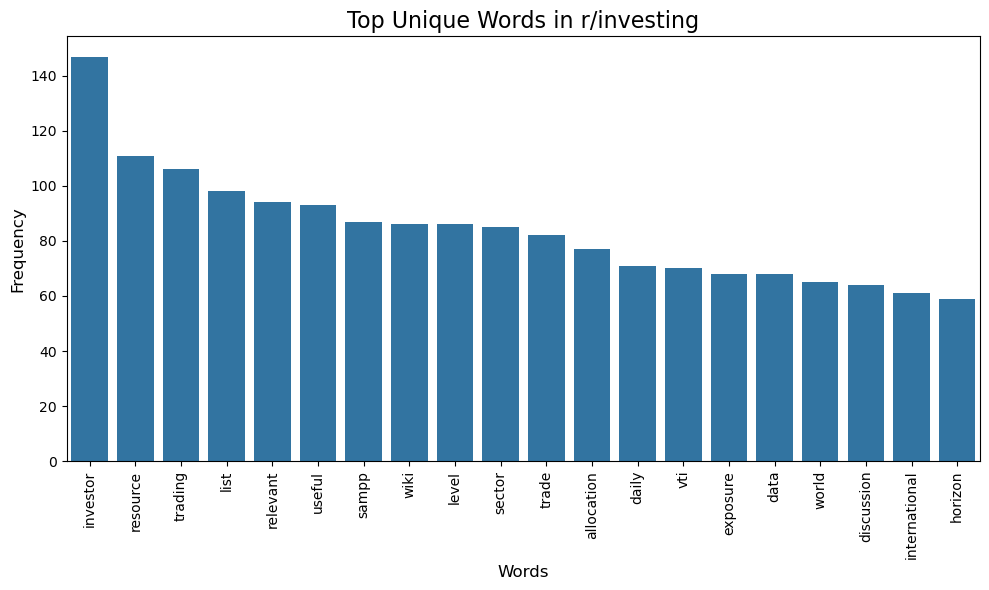

In [37]:
words = [item[0] for item in top_investing_unique]
counts = [item[1] for item in top_investing_unique]

plt.figure(figsize=(10, 6))
sns.barplot(x=words, y=counts)
plt.title('Top Unique Words in r/investing', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig(f'../images/top_investing_unique.png', bbox_inches='tight')
plt.show()

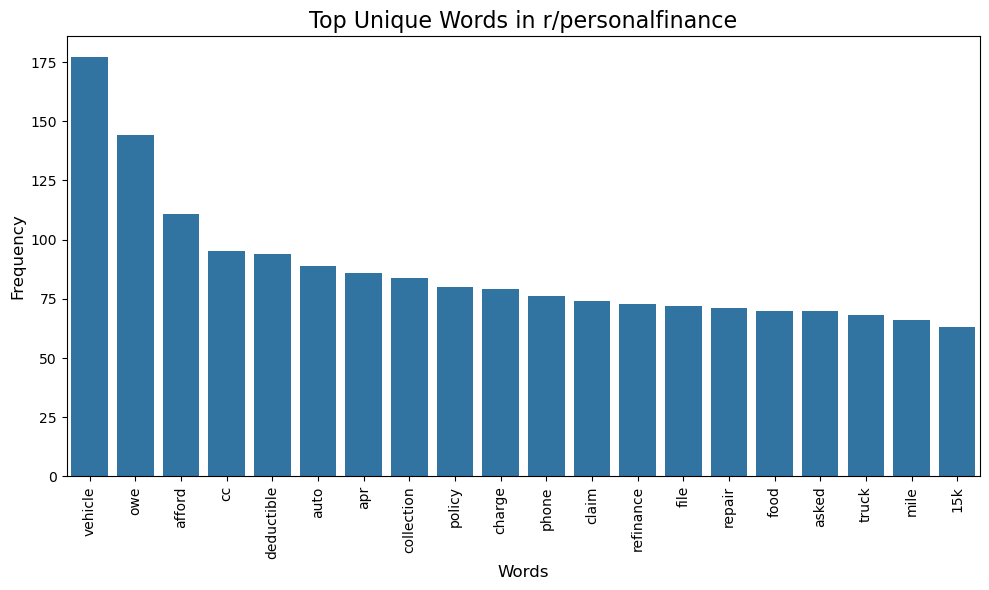

In [38]:
words = [item[0] for item in top_personalfinance_unique]
counts = [item[1] for item in top_personalfinance_unique]

plt.figure(figsize=(10, 6))
sns.barplot(x=words, y=counts)
plt.title('Top Unique Words in r/personalfinance', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig(f'../images/top_personalfinance_unique.png', bbox_inches='tight')
plt.show()

In [25]:
# Unique words for each subreddit
unique_investing_words = ['investor', 'resource', 'trading', 'list', 'relevant', 'useful', 'wiki', 'sampp', 'level', 'sector', 'trade', 'allocation', 'daily', 'vti', 'exposure', 'data', 'world', 'discussion', 'international', 'horizon']  
unique_personalfinance_words = ['vehicle', 'owe', 'afford', 'cc', 'deductible', 'auto', 'apr', 'collection', 'policy', 'charge', 'phone', 'claim', 'refinance', 'file', 'repair', 'food', 'asked', 'truck', 'mile', '15k']  

In [23]:
# Save new data frame 
reddit_df.to_csv('../data/preprocessed-data.csv', index=False)